# COVID19 - Análisis estadísticos y posible evolución

**23/3/2020 - Luis González Seco**

## Casos totales, sin altas

### Descarga de datos y pretratamiento

El siguiente estudio pretende analizar la evolución del COVID19, tomando los datos ofrecidos por el Ministerio de Salud del Gobierno de España, obtenidos a través del siguiente enlace puesto a disposición pública por un particular:

https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/ccaa_covid19_casos.csv

A continuación, se imporatan las librerías necesarias para la ejecución de la siguiente hoja de trabajo, y se obtiene el archivo con la información necesaria para el análisis.

In [16]:
import pandas as pd
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


from scipy import interpolate
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import numpy as np
plt.close('all')
plt.rcParams["figure.figsize"] = (20,8)

casos_totales = pd.read_csv('https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/ccaa_covid19_casos.csv', sep=',')


En la siguiente tabla, se muestrán los datos obtenidos de la fuente indicada. Cada fila representa una Comunidad Autónoma y cada columna las diferentes fechas consecutivas desde que se empezó a contabilizar los casos de coronavirus.

In [17]:
casos_totales

,cod_ine,CCAA,27/02/2020,28/02/2020,29/02/2020,01/03/2020,02/03/2020,03/03/2020,04/03/2020,05/03/2020,...,14/03/2020,15/03/2020,16/03/2020,17/03/2020,18/03/2020,19/03/2020,20/03/2020,21/03/2020,22/03/2020,23/03/2020
0,1,Andalucía,1,6,8,12,12,13,13,12,...,269,437,554,683,859,1008,1287,1515,1725,1961
1,2,Aragón,0,1,1,0,0,0,0,1,...,80,147,174,207,226,281,360,424,532,638
2,3,Asturias,0,0,0,1,1,1,2,5,...,92,137,177,193,242,292,344,486,545,594
3,4,Baleares,1,1,2,2,2,2,5,6,...,28,28,73,92,112,169,203,246,331,400
4,5,Canarias,6,6,6,7,7,7,7,8,...,90,109,119,148,181,220,287,348,414,481
5,6,Cantabria,0,0,0,1,10,10,10,10,...,31,51,58,58,68,83,144,215,282,347
6,8,Castilla-La Mancha,0,0,0,1,3,7,12,13,...,289,401,567,567,675,801,1044,1423,1819,2078
7,7,Castilla y León,0,2,2,3,3,8,11,11,...,223,292,334,431,668,868,1147,1466,1744,2055
8,9,Cataluña,2,3,5,6,15,15,15,24,...,509,715,903,1394,1866,2702,3270,4203,4704,5925
9,18,Ceuta,0,0,0,0,0,0,0,0,...,0,1,1,1,1,1,5,5,5,6


El estudio pretende centrarse en los datos totales, por lo que se ignorarán los datos de las demás Comunidades Autónomas. Con el siguiente código obtenemos la fila que realmente es útil para el análisis y se transpone para generar una columna.

In [18]:
total_index =  casos_totales['cod_ine'] == 0
transposed = casos_totales[total_index].transpose()[2:]
transposed.columns = ['Total']
transposed

,Total
27/02/2020,16
28/02/2020,32
29/02/2020,44
01/03/2020,66
02/03/2020,114
03/03/2020,150
04/03/2020,198
05/03/2020,237
06/03/2020,365
07/03/2020,430


###  Representación general

Se realizarán algunas operaciones para determinar la variación absoluta diaría. Esto es, el número de nuevos infectados respecto del día anterior. Tras realizar el cálculo, se muestra la evolución de casos infectados por el virus confirmados, junto con las variaciones absolutas obtenidas.

In [19]:
primer_dia = 0
analizar = 'Total'
valores_absolutos = []
for valor_actual in transposed[analizar]:
    valores_absolutos.append(valor_actual - primer_dia)
    primer_dia = valor_actual

nuevo = pd.DataFrame({'Valores absolutos': valores_absolutos}, index=transposed.index)

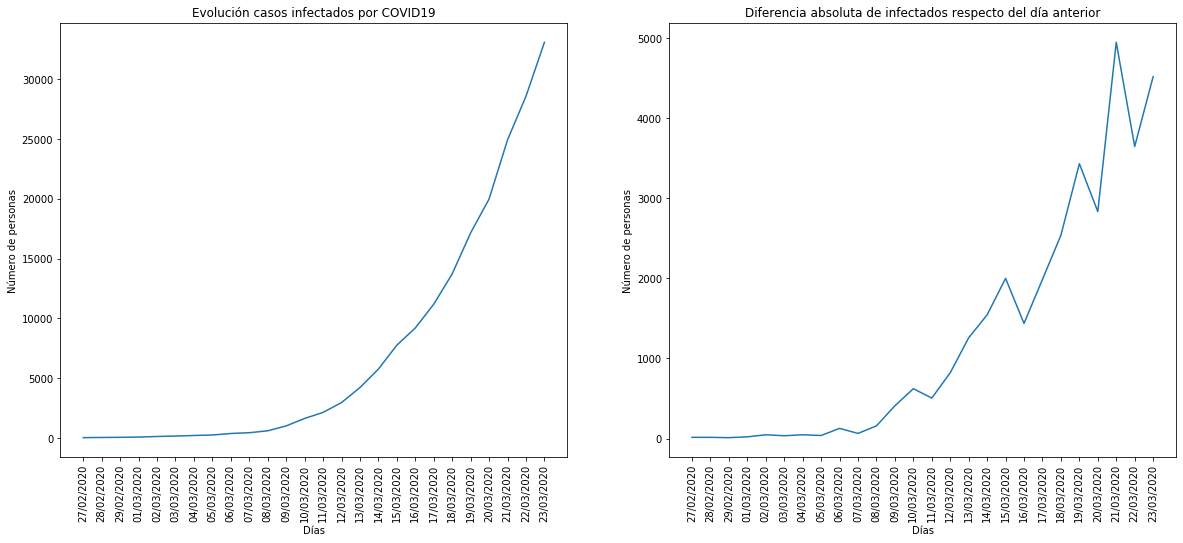

In [20]:
plt.subplot(121)
plt.ylabel('Número de personas')
plt.xlabel('Días')
plt.title('Evolución casos infectados por COVID19')
plt.xticks(rotation='vertical')
plt.plot(transposed)
plt.subplot(122)
plt.ylabel('Número de personas')
plt.xlabel('Días')
plt.title('Diferencia absoluta de infectados respecto del día anterior')
plt.xticks(rotation='vertical')
plt.plot(nuevo)
_ = plt.plot()

### Análisis de relaciones relativas

Es también interesante representar gráficamente las variaciones relativas de cada día. Esto se hará, calculando el porcentaje en el cuál el número de infectados aumento de un día para otro.

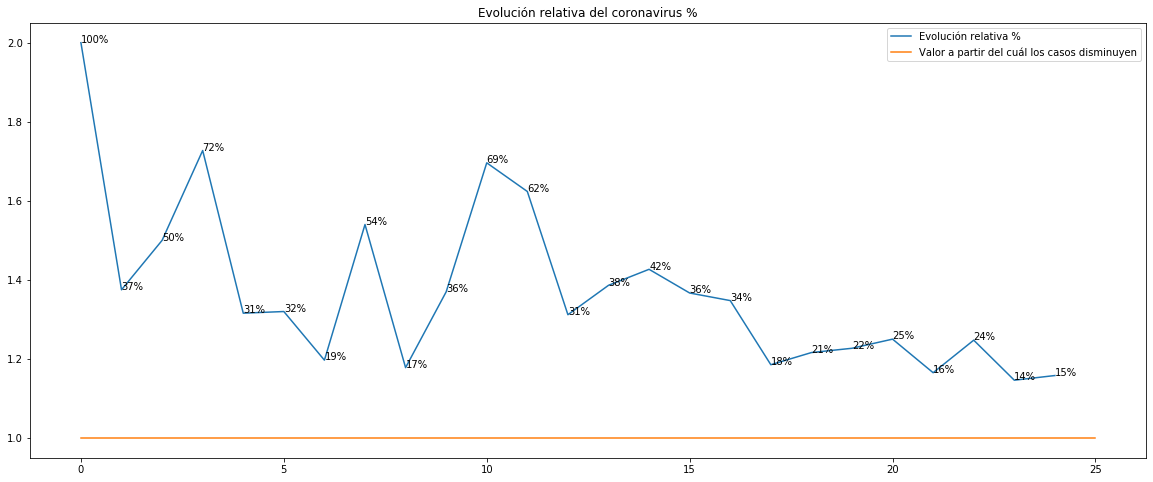

In [21]:
valor_dia_1 = 0

porcentajes = []
for valor_dia_2 in transposed[analizar]:
    if valor_dia_1:
        #porcentajes.append(100 * ( (valor_dia_2 / valor_dia_1) - 1))
        porcentajes.append(valor_dia_2 / valor_dia_1)
    valor_dia_1 = valor_dia_2

plt.plot(porcentajes)

for i, _y in enumerate(porcentajes):

    label = "{}%".format(int(100 * (_y - 1)))
    plt.annotate(label, (i, _y))

plt.title('Evolución relativa del coronavirus %')
linea, = plt.plot([0, len(porcentajes)], [1, 1])
plt.legend(['Evolución relativa %', 'Valor a partir del cuál los casos disminuyen'])
_ = plt.plot()

### Modelo predictivo

In [22]:
dias_prediccion = 60

y = porcentajes
x = np.arange(0, len(porcentajes))

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

x_pred = [i for i in range(0, dias_prediccion)]
y_pred = [p(i) for i in range(0, dias_prediccion)]

# Formateo del eje X a días
inicio = datetime.datetime.strptime('2020/02/28', '%Y/%m/%d')
fechas = [(inicio + timedelta(days=_x)).strftime('%Y/%m/%d') for _x in range(0, len(y_pred))]

En la gráfica mostrada a continuación se representa, en azul, la actual variación porcentual diaría. En rojo y punteado, la ecuación lineal que mejor se ajusta a la tendencia actual. Esta línea corta con la línea azul, umbral que determina a partir de cuando los casos empezarán a disminuir, en el día 1 de abril (línea naranja), día para el que se espera que el caso de infectados deje de aumentar.

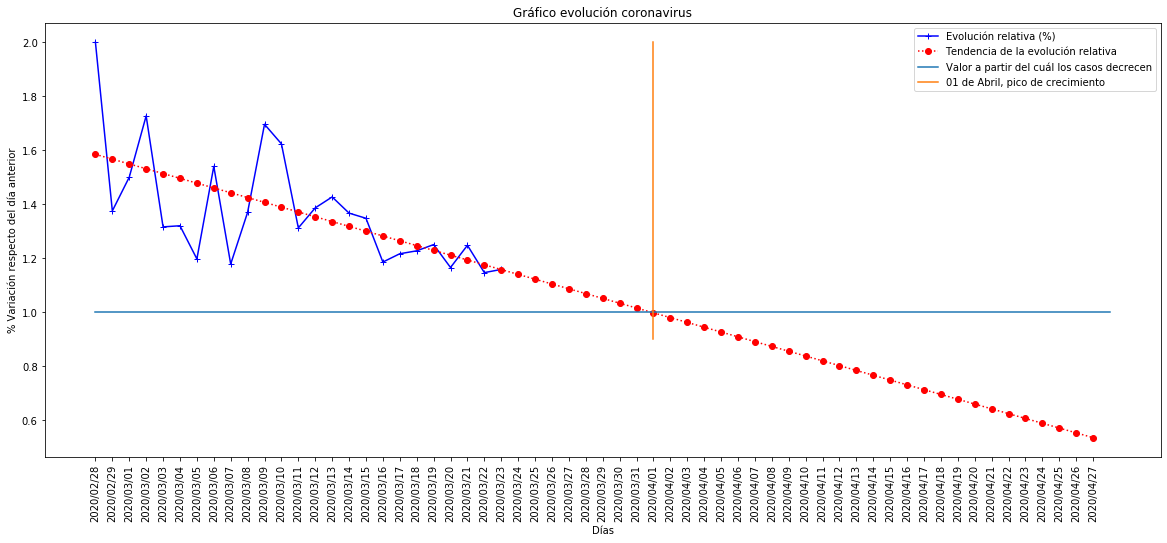

In [23]:

plt.plot(fechas[0:len(y)], y,'b+-',label='Evolución relativa (%)')
plt.plot(fechas, y_pred,'ro:',label='Tendencia de la evolución relativa')
plt.plot([0, dias_prediccion], [1, 1], label='Valor a partir del cuál los casos decrecen')
plt.plot([33, 33], [0.9, 2], label='01 de Abril, pico de crecimiento')
plt.xticks(rotation='vertical')

plt.legend()
plt.title('Gráfico evolución coronavirus')
plt.xlabel('Días')
plt.ylabel('% Variación respecto del día anterior')
plt.show()

In [24]:
lista_total = list(transposed[analizar])
porcentajes_diarios = y_pred[len(y):]
ultimo_valor = lista_total[-1]
proximos = []
for porcentaje_dia_n in porcentajes_diarios:
    #nuevo_valor = ultimo_valor * (1 + (porcentaje_dia_n / 100))
    nuevo_valor = ultimo_valor * porcentaje_dia_n
    proximos.append(nuevo_valor)
    ultimo_valor = nuevo_valor

El siguiente gráfico muestra la evolución de los infectados, siguiento la evolución de los porcentajes relativos que se ajustan a la situación actual.


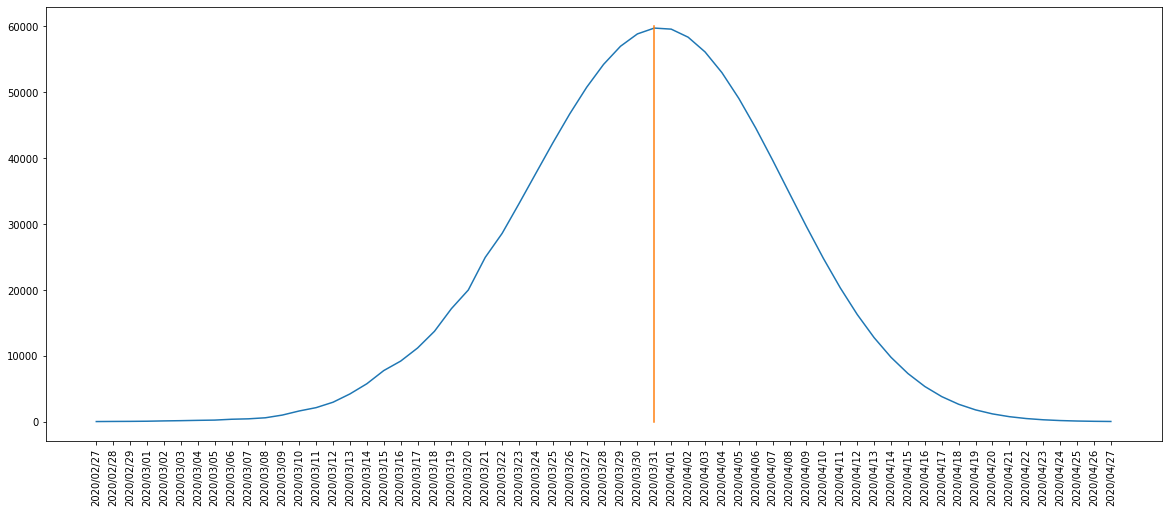

In [31]:
x_pred = [(inicio + timedelta(days = _x)).strftime('%Y/%m/%d') for _x in range(-1, dias_prediccion)]
curva_pred = list(transposed[analizar]) + proximos
plt.xticks(rotation = 'vertical')
plt.plot(x_pred, curva_pred)
plt.plot([33, 33], [0, 60000], label='31 de Marzo, pico de crecimiento')
_ = plt.plot()

### Previsiones para los próximos días.

En la siguiente tabla, se muestra la evolución diaria. Se indica el número de infectados contabilizados por cada día, encontrándose el pico del brote para el día 30 de Marzo 2020, con un valor cercano a los 60.000 infectados.

In [32]:
pd.DataFrame({"Proximos": curva_pred, "Fechas": x_pred})[24:50]

,Proximos,Fechas
24,28572.000000,2020/03/22
25,33089.000000,2020/03/23
26,37711.789001,2020/03/24
27,42309.091394,2020/03/25
28,46713.668856,2020/03/26
29,50745.210951,2020/03/27
30,54221.348030,2020/03/28
31,56970.386002,2020/03/29
32,58844.643355,2020/03/30
33,59733.039319,2020/03/31


### Verificación de la predicción. Grado de exactitud

Para tener una aproximación del grado de exactitud, habría que realizar el análisis, sin tener en cuenta el último día, para ver cuánto se aproxima el valor predicho al valor real. Tras el siguiente código, se muestra el gráfico que se hubiera obtenido el día anterior.

In [28]:
y_2 = porcentajes[:-1]
x_2 = np.arange(0, len(porcentajes))[:-1]

z_test = np.polyfit(x_2, y_2, 1)
p_test = np.poly1d(z)

x_test = [i for i in range(0, dias_prediccion)]
y_test = [p(i) for i in range(0, dias_prediccion)]

# Formateo del eje X a días
inicio = datetime.datetime.strptime('2020/02/28', '%Y/%m/%d')
fechas = [(inicio + timedelta(days=_x)).strftime('%Y/%m/%d') for _x in range(0, len(y_test))]

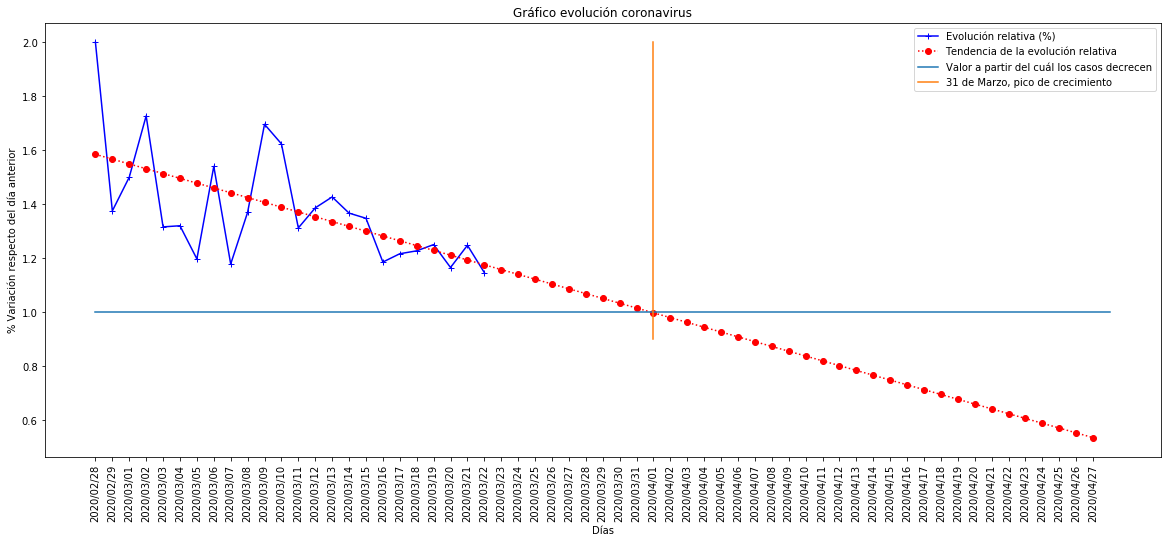

In [29]:
plt.plot(fechas[0:len(y_2)], y_2,'b+-',label='Evolución relativa (%)')
plt.plot(fechas, y_test,'ro:',label='Tendencia de la evolución relativa')
plt.plot([0, dias_prediccion], [1, 1], label='Valor a partir del cuál los casos decrecen')
plt.plot([33, 33], [0.9, 2], label='31 de Marzo, pico de crecimiento')
plt.xticks(rotation='vertical')

plt.legend()
plt.title('Gráfico evolución coronavirus')
plt.xlabel('Días')
plt.ylabel('% Variación respecto del día anterior')
plt.show()

In [30]:
proximo_porcentaje_l = y_pred[len(y_2): len(y_2) + 1]
proximo_porcentaje = proximo_porcentaje_l[0]
proximo_porcentaje_text = 100 * (proximo_porcentaje - 1)
valor_ayer = transposed[analizar][:-1][-1]
valor_hoy = transposed[analizar][-1]
valor_previsto = valor_ayer * proximo_porcentaje

precision = valor_hoy / valor_previsto if valor_previsto > valor_hoy else valor_previsto / valor_hoy
print ("Se estimaría que de ayer a hoy el porcentaje de crecimiento fuera: {}%".format(proximo_porcentaje))
print ("De esta manera, el valor previsto para hoy era: {}".format(valor_previsto))
print ("El valor real es: {}, por lo tanto el porcentaje de precision es {}%".format(valor_hoy, precision * 100))

Se estimaría que de ayer a hoy el porcentaje de crecimiento fuera: 1.1575092155744464%
De esta manera, el valor previsto para hoy era: 33072.35330739308
El valor real es: 33089, por lo tanto el porcentaje de precision es 99.94969115837009%
